# Combine all datasets

### Process human hippocampus data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *
from ALLCools.mcds import MCDS

In [2]:
import os
os.chdir("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/")

In [3]:
hh_adata = sc.read_h5ad("/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_5kb-CGN-hypo_cluster_bbknn_filtered_annotated_revision4.h5ad")

In [4]:
metadata = hh_adata.obs.copy()

In [5]:
sample_names = metadata["sample"].unique().to_list()
mcds_datasets = []
data_dir = "../"
from tqdm import tqdm
with tqdm(sample_names, desc="Opening") as pbar:
    for sample in pbar:
        pbar.set_postfix(current=sample)
        mcds = MCDS.open(
            os.path.join(data_dir, "{}_deep".format(sample), "allcools_analysis/{}Cell.mcds".format(sample)), 
            var_dim="chrom100k"
        )
        mcds = mcds.assign_coords(cell=["{}-{}".format(sample, c) for c in mcds.cell.values])
        mcds_datasets.append(mcds)

Opening: 100%|██████████| 44/44 [00:04<00:00,  9.29it/s, current=s6021]    


In [6]:
import xarray as xr
hh_dataset = xr.concat(mcds_datasets, dim="cell")

In [7]:
metadata_micro = metadata[metadata["final_cluster"].isin(["Micro1", "Micro2"])].copy()

In [8]:
hh_dataset = hh_dataset.sel(cell=metadata_micro.index)

In [9]:
mono_adata = MCDS.open("HumanCellEpigenomAtlas_Mono_2/HCEA_PBMC_mono2.mcds/", var_dim="chrom100k")

In [10]:
hh_mono_dataset = xr.concat([hh_dataset, mono_adata], dim="cell")

In [11]:
hh_mono_dataset

<xarray.MCDS>
Dimensions:          (chrom100k: 32350, count_type: 2, mc_type: 3, cell: 2934)
Coordinates:
  * chrom100k        (chrom100k) <U26 'chr1_0' ... 'chrY_KI270740v1_random_0'
  * count_type       (count_type) <U3 'mc' 'cov'
  * mc_type          (mc_type) <U3 'CAN' 'CGN' 'CHN'
  * cell             (cell) <U26 'hc1153-1-2-G11-AD001' ... 'PBMC_4809_Plate3...
    chrom100k_chrom  (chrom100k) <U23 'chr1' 'chr1' ... 'chrY_KI270740v1_random'
    chrom100k_end    (chrom100k) int64 100000 200000 300000 ... 57227415 37240
    chrom100k_start  (chrom100k) int64 0 100000 200000 ... 57100000 57200000 0
Data variables:
    chrom100k_da     (cell, chrom100k, mc_type, count_type) uint32 dask.array<chunksize=(1, 8088, 1, 1), meta=np.ndarray>
Attributes:
    obs_dim:  null
    var_dim:  null

### Pre-processing

In [12]:
obs_dim = "cell"
var_dim = "chrom100k"

In [13]:
hh_mono_dataset.obs_dim = "cell"
hh_mono_dataset.var_dim = "chrom100k"

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


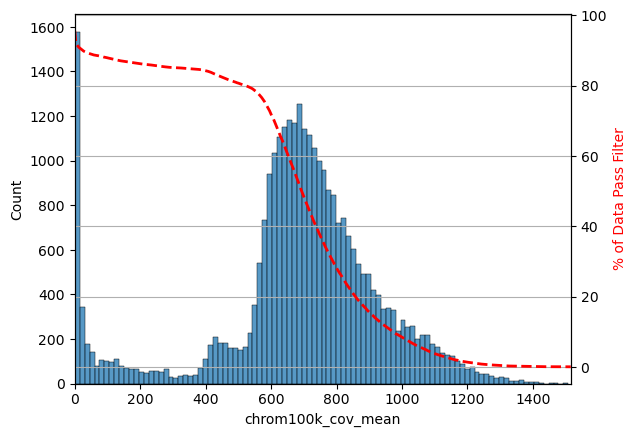

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [14]:
hh_mono_dataset.add_feature_cov_mean(var_dim=var_dim)

In [15]:
hh_mono_dataset = hh_mono_dataset.filter_feature_by_cov_mean(
    min_cov=300,
    max_cov=1500
)
black_list_path = "../../../genome/hg38_blacklist.v2.bed.gz"
hh_mono_dataset = hh_mono_dataset.remove_black_list_region(
    black_list_path=black_list_path,
    f=0.2
)
hh_mono_dataset = hh_mono_dataset.remove_chromosome(["chrM", "chrY", "chrX"])

Before cov mean filter: 32350 chrom100k
 After cov mean filter: 27512 chrom100k 85.0%
260 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.
1395 chrom100k features in ['chrM', 'chrY', 'chrX'] removed.


In [16]:
hh_mono_dataset.add_mc_frac(normalize_per_cell=False)
load = True
if load and (hh_mono_dataset.get_index(obs_dim).size < 20000):
    hh_mono_dataset[f"{var_dim}_da_frac"].load()

In [17]:
mch_adata = hh_mono_dataset.get_adata(
    mc_type="CHN",
    var_dim=var_dim,
    select_hvf=False
)
mch_adata

AnnData object with n_obs × n_vars = 2934 × 25861
    var: 'chrom', 'end', 'start', 'cov_mean'

In [18]:
mch_adata.write_h5ad("hh_mono_CHN_chrom100k.mcad")

In [19]:
mcg_adata = hh_mono_dataset.get_adata(
    mc_type="CGN",
    var_dim=var_dim,
    select_hvf=False
)
mcg_adata

AnnData object with n_obs × n_vars = 2934 × 25861
    var: 'chrom', 'end', 'start', 'cov_mean'

In [20]:
mcg_adata.write_h5ad("hh_mono_CGN_chrom100k.mcad")

## Combine with developing data

In [5]:
dev_metadata = pd.read_csv("DevelopingHumanBrain_MGC/meta.tsv", header=0, sep="\t")
dev_metadata.set_index("Cell_Id", inplace=True)

In [6]:
hh_mono_mcg_adata = sc.read_h5ad("hh_mono_CGN_chrom100k.mcad")
fetal_mcg_adata = sc.read_h5ad("DevelopingHumanBrain_MGC/processed/mCG_raw.mcad")
hh_mono_mcg_adata.obs["final_cluster"] = "Monocyte"
hh_cells = hh_mono_mcg_adata.obs_names[hh_mono_mcg_adata.obs_names.isin(metadata.index)]
hh_mono_mcg_adata.obs.loc[hh_cells, "final_cluster"] = metadata.loc[hh_cells, "final_cluster"]
fetal_mcg_adata.obs["final_cluster"] = "Fetal_MGC"
shared_regions = hh_mono_mcg_adata.var_names.intersection(fetal_mcg_adata.var_names)
hh_mono_mcg_adata = hh_mono_mcg_adata[:, shared_regions].copy()
fetal_mcg_adata = fetal_mcg_adata[:, shared_regions].copy()
mcg_adata = hh_mono_mcg_adata.concatenate([fetal_mcg_adata])

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [7]:
mcg_adata.obs["final_cluster"].value_counts()

Micro1       1329
Micro2       1275
Fetal_MGC     405
Monocyte      330
Name: final_cluster, dtype: int64

In [8]:
binarize_matrix(mcg_adata, cutoff=0.75)
filter_regions(mcg_adata)

25814 regions remained.


In [9]:
lsi(mcg_adata, algorithm="arpack", obsm="X_pca")
n_components = significant_pc_test(mcg_adata, p_cutoff=0.1, update=True)

8 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (3339, 100) to (3339, 8)


In [10]:
sc.pp.neighbors(mcg_adata)
sc.tl.leiden(mcg_adata, resolution=1)

In [11]:
try:
    sc.tl.paga(mcg_adata, groups="leiden")
    sc.pl.paga(mcg_adata, plot=False)
    sc.tl.umap(mcg_adata, init_pos="paga")
except:
    sc.tl.umap(mcg_adata)

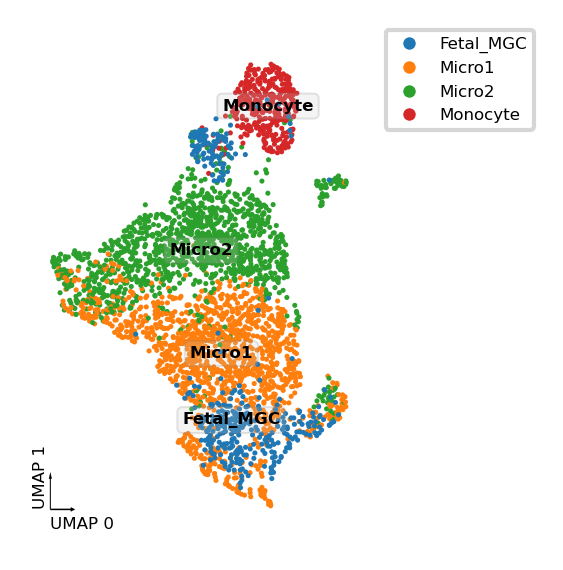

In [12]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
_ = categorical_scatter(
    data=mcg_adata,
    ax=ax,
    coord_base="umap",
    hue="final_cluster",
    text_anno="final_cluster",
    show_legend=True
)
plt.tight_layout()

In [13]:
dev_metadata.index = dev_metadata.index.astype(str) + "-1"
dev_cells = mcg_adata.obs_names[mcg_adata.obs_names.isin(dev_metadata.index)]

In [22]:
mcg_adata.obs["final_cluster"] = mcg_adata.obs["final_cluster"].astype(str)
mcg_adata.obs.loc[dev_cells, "final_cluster"] = dev_metadata.loc[dev_cells, "L3"]

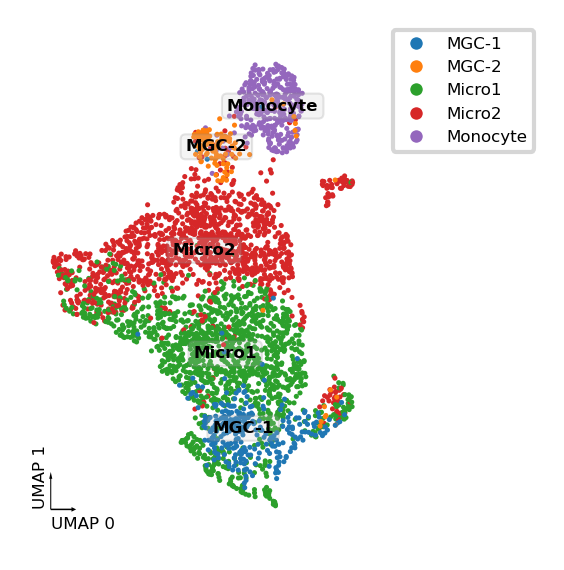

In [23]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
_ = categorical_scatter(
    data=mcg_adata,
    ax=ax,
    coord_base="umap",
    hue="final_cluster",
    text_anno="final_cluster",
    show_legend=True,
    rasterized=False
)
plt.tight_layout()
plt.savefig("results/hh_mono_fetal_micro_only.pdf", dpi=300)

In [24]:
mcg_adata.obs["final_cluster"] = mcg_adata.obs["final_cluster"].astype(str)
mcg_adata.obs.loc[dev_cells, "final_cluster"] = dev_metadata.loc[dev_cells, "Age_groups"]

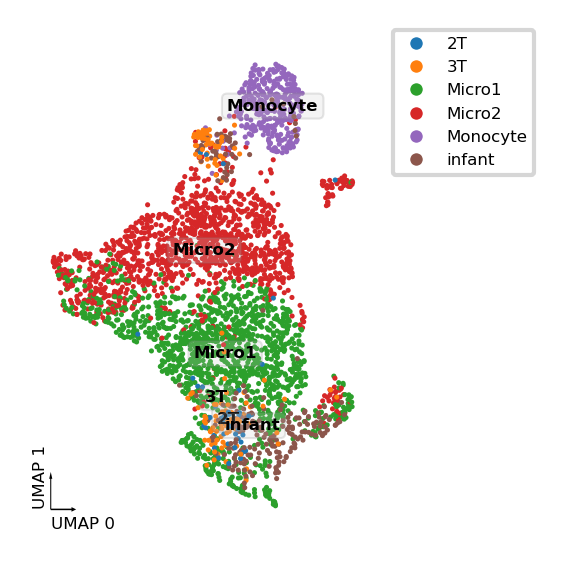

In [25]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
_ = categorical_scatter(
    data=mcg_adata,
    ax=ax,
    coord_base="umap",
    hue="final_cluster",
    text_anno="final_cluster",
    show_legend=True,
    rasterized=False,
)
plt.tight_layout()
plt.savefig("results/hh_mono_fetal_micro_only_age.pdf", dpi=300)